## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Notebook config

In [19]:
#Cities are dam names ('presa_laboca', 'presa_cerroprieto', 'presa_elcuchillo')
city = 'presa_elcuchillo'
res = 11

# Analysis name
index_analysis = 'ndwi'

# Analysed raster data from local directory:
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

#DATA ANALYSIS - Calculate graph of monthly behaviour by year?
seasonal_behaviour = True

#DATA ANALYSIS - Calculate bar charts of categorical behaviour by dam?
barplot_behaviour = True

#DATA ANALYSIS - Plot dam by date?
plot_bydate = True

#EXPORT DATA - Save plots in output?
save_plots = False

#Save space in disk deleting data not used again?
save_diskspace = True

## Data download

### Data download - Dam polygon (area of interest)

<Axes: >

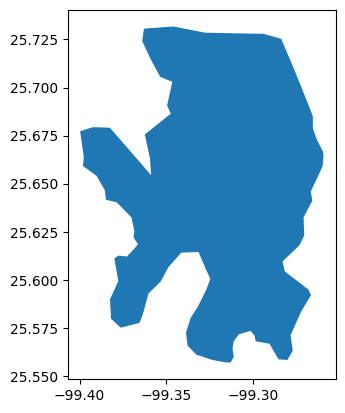

In [3]:
poly = gpd.read_file(f"../../../data/external/temporal_todocker/{city}.gpkg")

poly.reset_index(inplace=True)
columns_tokeep = ['Name','geometry']
poly = poly[columns_tokeep]

# Show
poly.plot()

### Data download - Raster analysis data

Download data

In [7]:
ndwi_hex = gpd.read_file(tmp_dir+f"local_save/{city}_ndwi_HexRes{res}_v0.geojson")

# Show
print(ndwi_hex.shape)
ndwi_hex.head(2)

(83351, 11)


,hex_id,res,ndwi_mean,ndwi_std,ndwi_median,ndwi_max,ndwi_min,ndwi_diff,ndwi_tend,city,geometry
0,8b48b1909916fff,11,-0.531567,0.134414,-0.587283,-0.402036,-0.635893,0.233856,0.000563,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572..."
1,8b48b1908b61fff,11,-0.541328,0.143369,-0.590549,-0.455071,-0.648933,0.193863,0.001390,presa_elcuchillo,"POLYGON ((-99.32424 25.56636, -99.32406 25.566..."


Clip data to area of interest

<Axes: >

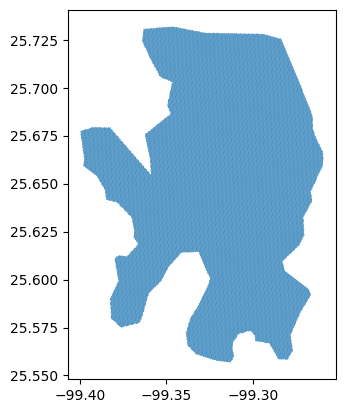

In [8]:
# Find hex centroids
gdf = ndwi_hex.to_crs("EPSG:6372")
centroids = gdf.centroid
centroids = centroids.to_crs("EPSG:4326")

# Turn them into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

# Intersect centroids with original analysed_raster to keep hex_id in centroids
centroids_hexid = gpd.overlay(centroids_gdf,ndwi_hex,keep_geom_type=True)
columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

# Intersect spatially centroids with dam
centroids_hexid_dam = gpd.overlay(centroids_hexid,poly,keep_geom_type=True)

# Select hexagons from centroids's hex_id
centroids_hexid_dam_f = centroids_hexid_dam['hex_id']
ndwi_hex_dams = pd.merge(centroids_hexid_dam_f,ndwi_hex, on='hex_id')
ndwi_hex_dams = ndwi_hex_dams.set_geometry('geometry')

#Save space in disk deleting:
if save_diskspace:
    del ndwi_hex
    del centroids
    del centroids_gdf
    del centroids_hexid
    del centroids_hexid_dam
    del centroids_hexid_dam_f
    
# Show
ndwi_hex_dams.plot()

### Data download - Complete dataset

In [9]:
# Load data
complete_dataset = pd.read_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{res}_v0.csv')

# Format
complete_dataset = complete_dataset.drop(columns=['Unnamed: 0'])

# Filter (Keeps data for hexs within area of interest)
gdf1 = ndwi_hex_dams.copy()[['hex_id','res','city','geometry']]
df2 = complete_dataset.copy()[['hex_id','ndwi','month', 'year']]

complete_dataset_dams = pd.merge(gdf1, df2, how='inner', on='hex_id')

#Save space in disk deleting:
if save_diskspace:
    del gdf1
    del df2
    del complete_dataset

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(6268386, 7)


,hex_id,res,city,geometry,ndwi,month,year
0,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.547333,1,2016
1,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.463594,2,2016


## Data treatment

### Data treatment - Create datetime data

In [10]:
#Creates datetime data by adding month (string) + / + year (string)
complete_dataset_dams['date'] = pd.to_datetime(complete_dataset_dams['month'].astype(str) + '/' + complete_dataset_dams['year'].astype(str))

#Strips the day, leaving month and year
complete_dataset_dams['date'] = complete_dataset_dams['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(6268386, 8)


,hex_id,res,city,geometry,ndwi,month,year,date
0,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.547333,1,2016,2016-01
1,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.463594,2,2016,2016-02


### Data treatment - Create raster categories (from documentation)

In [11]:
# Creating vegetation categories
complete_dataset_dams['ndwi_category'] = np.nan

complete_dataset_dams.loc[complete_dataset_dams.ndwi>=0.2 , 'ndwi_category'] = 'Water surface'        
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=0.0)&
             (complete_dataset_dams.ndwi<0.2), 'ndwi_category'] = 'Flooding, humidity'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=-0.3)&
             (complete_dataset_dams.ndwi<0.0), 'ndwi_category'] = 'Moderate drought, non-aqueous surfaces'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi<-0.3), 'ndwi_category'] = 'Drought, non-aqueous surfaces'

# Ordering data
categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
complete_dataset_dams['ndwi_category'] = pd.Categorical(complete_dataset_dams['ndwi_category'], categories=categories, ordered=True)

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(6268386, 9)


,hex_id,res,city,geometry,ndwi,month,year,date,ndwi_category
0,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.547333,1,2016,2016-01,"Drought, non-aqueous surfaces"
1,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.463594,2,2016,2016-02,"Drought, non-aqueous surfaces"


### Data treatment - Differenciate hex with and without water (from experience)

In [12]:
#Select surfaces with water
water_list = ['Flooding, humidity', 'Water surface']

#Differenciate
complete_dataset_dams.loc[:,'hex_water'] = complete_dataset_dams['ndwi_category'].apply(lambda x: 1 if x in water_list else 0)

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(6268386, 10)


,hex_id,res,city,geometry,ndwi,month,year,date,ndwi_category,hex_water
0,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.547333,1,2016,2016-01,"Drought, non-aqueous surfaces",0
1,8b48b1909916fff,11,presa_elcuchillo,"POLYGON ((-99.33377 25.57186, -99.33358 25.572...",-0.463594,2,2016,2016-02,"Drought, non-aqueous surfaces",0


## Data analysis

### Data analysis - Summary data by date

In [13]:
#Calculate average hex area according to resolution and location
available_dates = len(complete_dataset_dams.date.unique())
data_rows = available_dates

#Empty historical behaviour dataset
behaviour_bydate = pd.DataFrame()

#Summarize data
#Loop for each city (dam)
for city in complete_dataset_dams.city.unique():

    #Create empty temporary dataFrame
    cols = ['date', 'mean_ndwi']
    temp_df = pd.DataFrame(columns=cols, index=range(data_rows)) # rows = available dates * available categories
    temp_df['city'] = city 

    #Loop for each row (date)
    count = 0

    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD (dam)
    complete_bycity = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    #Loop for each date in city (Dam)
    for date in complete_bycity.date.unique():
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD (dam) Y LA FECHA.
        complete_bydate = complete_bycity.loc[(complete_bycity.date == date)]
        
        #Find data
        ndwi_value = complete_bydate.ndwi.mean()
        #Register data in DataFrame
        temp_df.loc[count,'date'] = date
        temp_df.loc[count,'mean_ndwi'] = ndwi_value

        #Loop for each raster category in the date in the city (dam)
        categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
        
        for cat in categories:
            #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD, LA FECHA Y LA CATEGORÍA.
            complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]

            #Find data
            hexcount = complete_bydate_cat.shape[0]
            #Register data
            temp_df.loc[count, cat] = hexcount

        #Next row (date) in city (dam) dataFrame
        count = count + 1

    #When all dates of city are over, concat and re-start count and data for following city (dam)
    behaviour_bydate = pd.concat([behaviour_bydate,temp_df])
    
    #Save space in disk deleting:
    if save_diskspace:
        del complete_bycity
        del complete_bydate
        del temp_df

#Save date data
behaviour_bydate['month'] = behaviour_bydate['date'].apply(lambda x: pd.Timestamp(x).month)
behaviour_bydate['year'] = behaviour_bydate['date'].apply(lambda x: pd.Timestamp(x).year)

#Final format
behaviour_bydate = behaviour_bydate[['date','year','month','mean_ndwi',
                                     'Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 
                                     'Flooding, humidity', 'Water surface','city']]

#Show
print(behaviour_bydate.shape)
behaviour_bydate.head(2)

(93, 9)


,date,year,month,mean_ndwi,"Drought, non-aqueous surfaces","Moderate drought, non-aqueous surfaces","Flooding, humidity",Water surface,city
0,2016-01,2016,1,0.272051,18406.0,1743.0,1010.0,46243.0,presa_elcuchillo
1,2016-02,2016,2,0.464186,16848.0,3204.0,890.0,46460.0,presa_elcuchillo


### Data analysis - Data tendency

In [14]:
import pymannkendall as mk

for city in behaviour_bydate.city.unique():
    
    #Data for each dam
    behaviour_bycity = behaviour_bydate.loc[(behaviour_bydate.city == city)]
    behaviour_bycity = behaviour_bycity[['date','mean_ndwi']]
    
    #Mann-Kendall Test 
    test = mk.original_test(behaviour_bycity['mean_ndwi'])
    print('{}'.format(city))
    print('{}'.format(test))

presa_elcuchillo
Mann_Kendall_Test(trend='decreasing', h=True, p=2.2712498548571602e-11, z=-6.687429728000693, Tau=-0.47124824684431976, s=-2016.0, var_s=90788.66666666667, slope=-0.003898341462572737, intercept=0.30352950747280916)


### Data analysis - Seasonal (by month) graphed behaviour

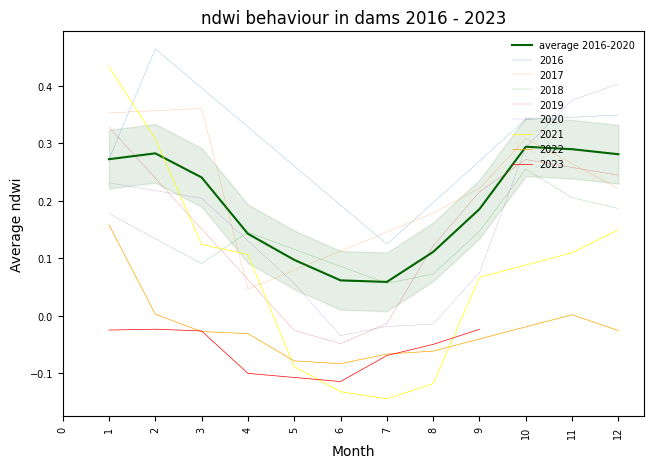

In [15]:
if seasonal_behaviour:
    columns_tokeep = ['date','month','percentage']

    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    complete_dataset_dams_f = complete_dataset_dams.loc[complete_dataset_dams.year <= 2020]
    complete_bymonth = complete_dataset_dams_f.groupby('month').agg({'month':np.mean,'ndwi':np.mean})

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth.ndwi
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(x,y, label = 'average 2016-2020',color = 'darkgreen')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- MONTHLY DATA (dotted lines) ----------

    # Find all data years
    available_years = list(complete_dataset_dams['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        year_dataset_dams = complete_dataset_dams.loc[(complete_dataset_dams.year == current_year)]
        #Grouping by month    
        data_bymonth = year_dataset_dams.groupby('month').agg({'ndwi':np.mean})
        #Plotting
        if current_year == 2021:
            plt.plot(data_bymonth, linewidth = 0.5, label=current_year,c='yellow');
        elif current_year == 2022:
            plt.plot(data_bymonth, linewidth = 0.5, label=current_year,c='orange');
        elif current_year == 2023:
            plt.plot(data_bymonth, linewidth = 0.5, label=current_year,c='red'); 
        else:
            plt.plot(data_bymonth, '--', linewidth = 0.20, label=current_year);


    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('ndwi behaviour in dams 2016 - 2023')
    plt.xlabel('Month')
    plt.ylabel('Average ndwi')

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=1, 
               fontsize = 7)

    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndwi/ndwi_behaviour_dams_lineplot.svg")

### Data analysis - Summarize data by date in new dataframe

In [16]:
if barplot_behaviour:
    
    #Calculate average hex area according to resolution and location
    available_dates = len(complete_dataset_dams.date.unique())
    data_rows = available_dates*4
    print("There is a total of {} dates, each date has is data divided in 4 categories for a total of {} data rows for each city(dam).".format(available_dates,data_rows))

    #Empty historical behaviour dataset
    historical_behaviour = pd.DataFrame()

    #Summarize data
    #Loop for each city (dam)
    for city in complete_dataset_dams.city.unique():

        #Create empty temporary dataFrame
        cols = ['date', 'ndwi_category', 'hexcount']
        historical_temp = pd.DataFrame(columns=cols, index=range(data_rows)) # rows = available dates * available categories
        historical_temp['city'] = city 

        #Loop for each row (date)
        count = 0

        #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
        complete_bycity = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

        #Loop for each date in city
        for date in complete_bycity.date.unique():
            #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
            complete_bydate = complete_bycity.loc[(complete_bycity.date == date)]

            #Loop for each raster category in the date in the city (dam)
            for cat in categories:
                #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD, LA FECHA Y LA CATEGORÍA.
                complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]

                hexcount = complete_bydate_cat.shape[0]

                #Register data in DataFrame
                historical_temp.loc[count].date = date
                historical_temp.loc[count].ndwi_category = cat
                historical_temp.loc[count].hexcount = hexcount

                #Next row (date) in city (dam) dataFrame
                count = count + 1

        #When all dates of city are over, concat and re-start count and data for following city (dam)
        historical_behaviour = pd.concat([historical_behaviour,historical_temp])

    #Save month data
    historical_behaviour['month'] = historical_behaviour['date'].apply(lambda x: pd.Timestamp(x).month)

    #Show
    print(historical_behaviour.shape)
    print(historical_behaviour.head(2))

There is a total of 93 dates, each date has is data divided in 4 categories for a total of 372 data rows for each city(dam).
(372, 5)
      date                           ndwi_category hexcount              city  \
0  2016-01           Drought, non-aqueous surfaces    18406  presa_elcuchillo   
1  2016-01  Moderate drought, non-aqueous surfaces     1743  presa_elcuchillo   

   month  
0      1  
1      1  


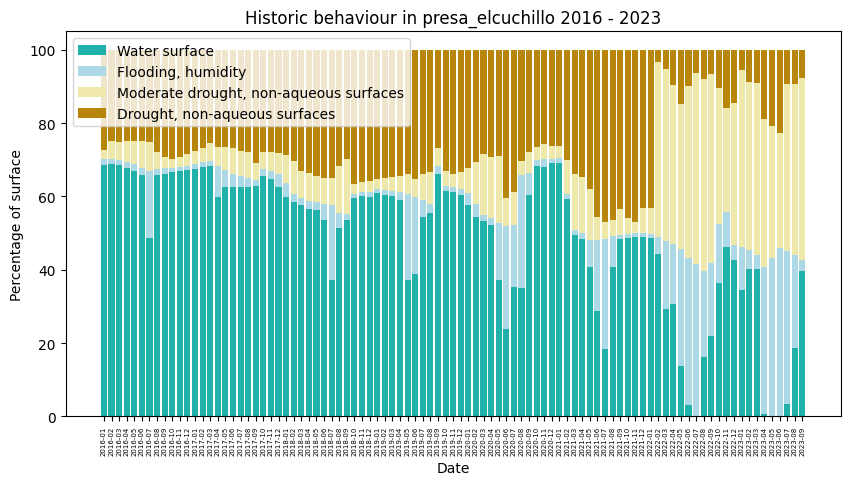

In [22]:
if barplot_behaviour:

    #Iterate over each city
    for city in historical_behaviour.city.unique():

        #--------------- Isolate data for dam and clean data ---------------
        historicalbehaviour_dam = historical_behaviour.loc[(historical_behaviour.city == city)]

        #--------------- Create series of data ---------------
        columns_tokeep = ['date','hexcount']

        water = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Water surface')]
        water = water.reset_index()
        water = water[columns_tokeep]

        flood = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Flooding, humidity')]
        flood = flood.reset_index()
        flood = flood[columns_tokeep]

        moderate = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Moderate drought, non-aqueous surfaces')]
        moderate = moderate.reset_index()
        moderate = moderate[columns_tokeep]

        drought = historicalbehaviour_dam.loc[(historicalbehaviour_dam.ndwi_category == 'Drought, non-aqueous surfaces')]
        drought = drought.reset_index()
        drought = drought[columns_tokeep] 

        #--------------- Plot data ---------------
        x = water['date']
        y1 = (water['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
        y2 = (flood['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
        y3 = (moderate['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100
        y4 = (drought['hexcount'] / (water['hexcount']+flood['hexcount']+moderate['hexcount']+drought['hexcount']))*100

        plt.figure(figsize=(10,5))
        plt.bar(x, y1, color='lightseagreen',label='Water surface')
        plt.bar(x, y2, bottom=y1, color='lightblue',label='Flooding, humidity')
        plt.bar(x, y3, bottom=y1+y2, color='palegoldenrod',label='Moderate drought, non-aqueous surfaces')
        plt.bar(x, y4, bottom=y1+y2+y3, color='darkgoldenrod',label='Drought, non-aqueous surfaces')


        # ---------- Format ----------
        # Format - Titles
        plt.title('Historic behaviour in {} 2016 - 2023'.format(city))
        plt.xlabel('Date')
        plt.ylabel('Percentage of surface')

        # Format - x ticks
        # Rotate ticks
        x = plt.gca().xaxis
        for item in x.get_ticklabels():
            item.set_rotation(90)
            item.set_size(5)

        # Format - Legend
        plt.legend(frameon=False,
                   loc='upper left',
                   fontsize = 5)

        legend = plt.legend(frameon = 1)
        legend.fontsize = 5
        frame = legend.get_frame()
        frame.set_facecolor('white')

        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig("../../../output/figures/ndwi/historic_barplot_{}.svg".format(city))

### Data analysis - Plot by date

/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


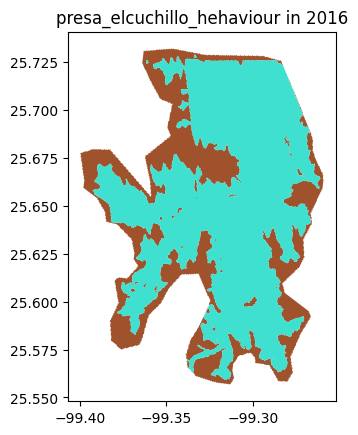

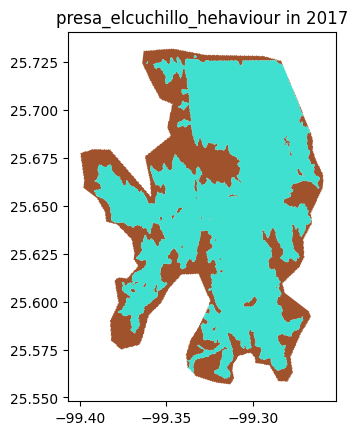

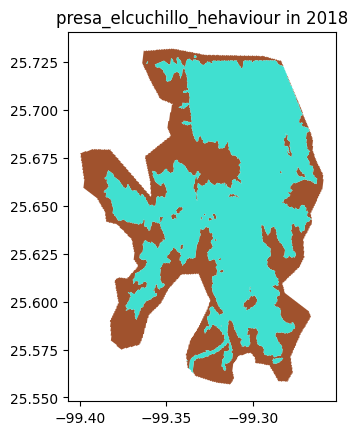

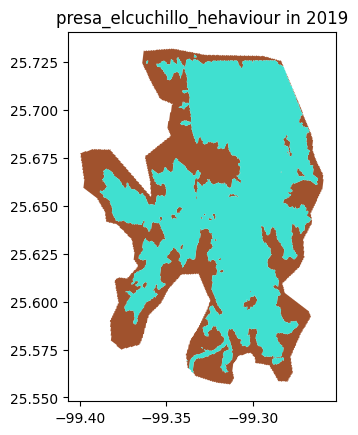

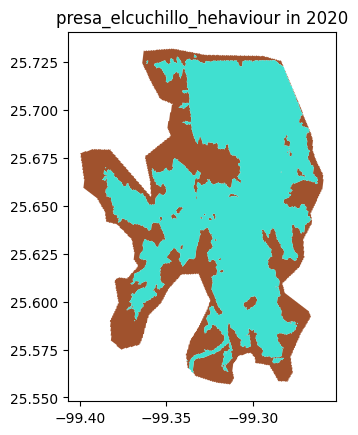

In [29]:
if plot_bydate:

    #------------------------------ Select data ------------------------------
    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
    complete_dataset_dams_city = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    years_summary = [2016,2017,2018,2019,2020]

    #Loop for each year in city
    for year in years_summary:
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
        by_year = complete_dataset_dams_city.loc[(complete_dataset_dams_city.year == year)]
        year_meandataset_byhex = by_year.groupby('hex_id').agg({'ndwi':np.mean})

        # Creating categories
        year_meandataset_byhex['water_hex'] = np.nan

        year_meandataset_byhex.loc[year_meandataset_byhex.ndwi>=0.0 , 'water_hex'] = 'Water'        
        year_meandataset_byhex.loc[(year_meandataset_byhex.ndwi<-0.0), 'water_hex'] = 'Non-aqueous surfaces'
        
        # Ordering data
        categories = ['Non-aqueous surfaces', 'Water']
        year_meandataset_byhex['water_hex'] = pd.Categorical(year_meandataset_byhex['water_hex'], categories=categories, ordered=True)
        
        #Merge data with geometry
        gdf1 = ndwi_hex_dams.copy()[['hex_id','geometry']]
        df2 = year_meandataset_byhex.reset_index()

        year_meandataset_geom = pd.merge(gdf1, df2, how='inner', on='hex_id')
        
        #Dissolve geometry
        year_meandataset_geom = year_meandataset_geom.to_crs("EPSG:6372")
        water_shape = year_meandataset_geom.dissolve('water_hex')
        water_shape = water_shape.to_crs("EPSG:4326")
        water_shape.reset_index(inplace=True)
        water_shape = water_shape[['water_hex','geometry']]
        
        # ---------- Plot ----------
        #Date behaviour
        water_shape.plot(column="water_hex",
                         legend=True, color = ['sienna','turquoise'])

        # ---------- Format ----------
        # Format - Titles
        plt.title('{}_hehaviour in {}'.format(city,year))
        
        # ---------- Save disk space ----------
        if save_diskspace:
            del by_year
            del year_meandataset_byhex
            del gdf1
            del df2
            del water_shape

        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig("../../../output/figures/ndwi/maps_{}/{}_hehaviour in {}.svg".format(city,city,year))

/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/python/lib/python3.10/site-

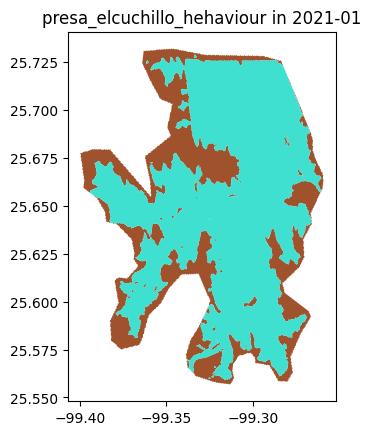

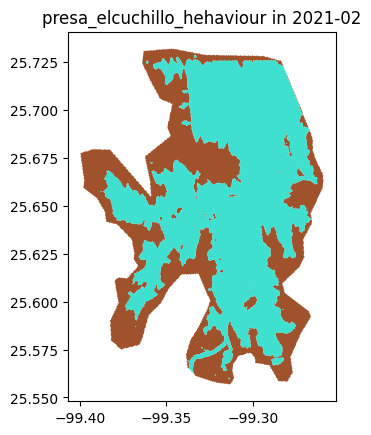

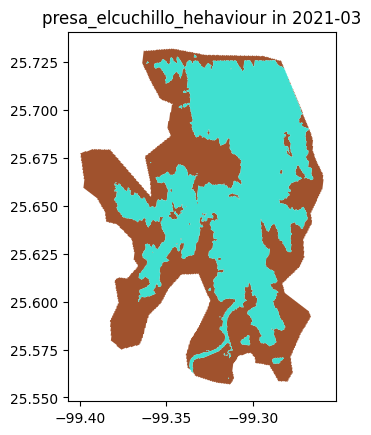

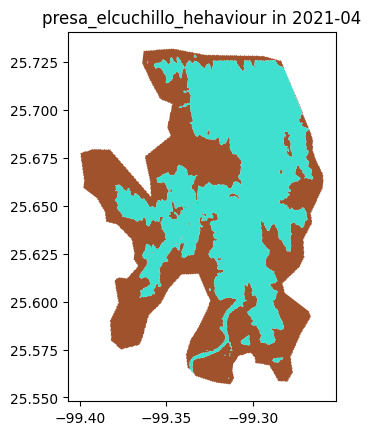

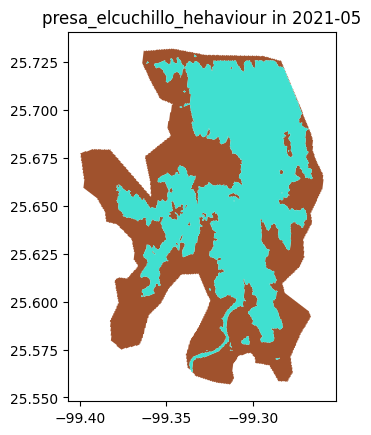

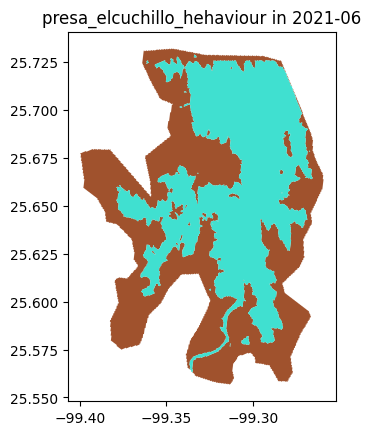

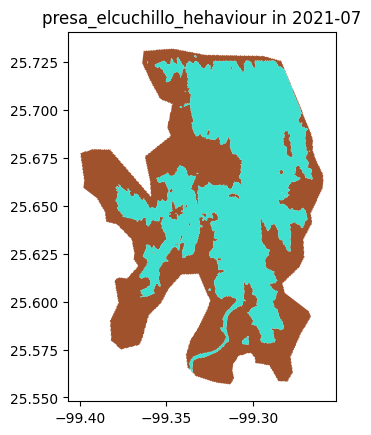

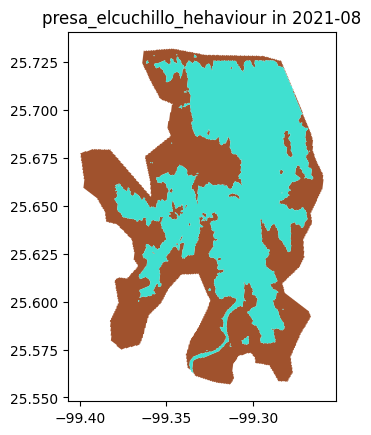

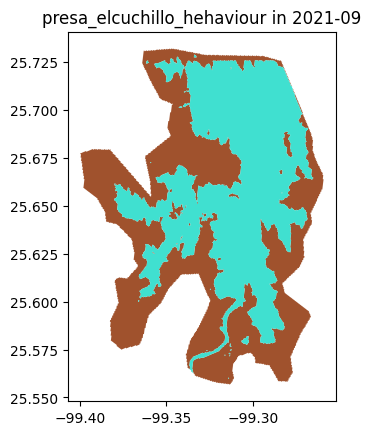

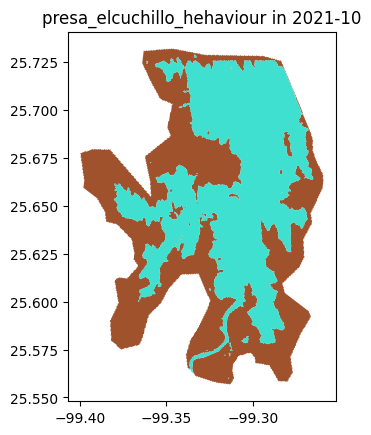

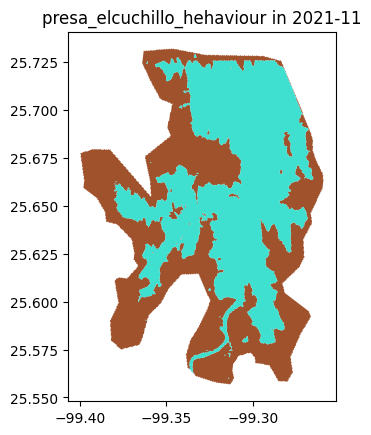

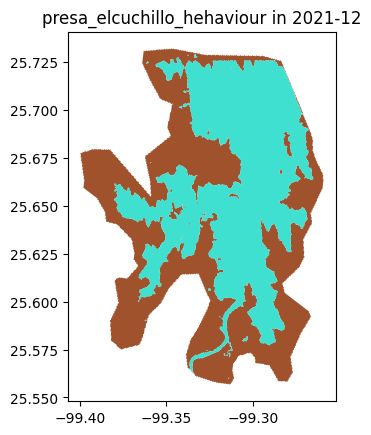

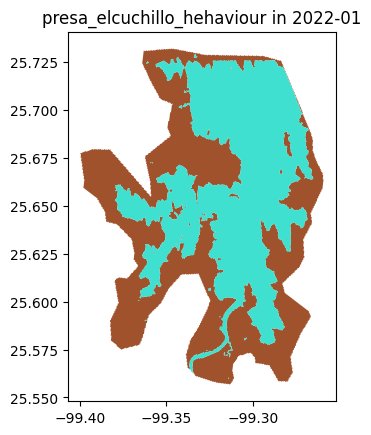

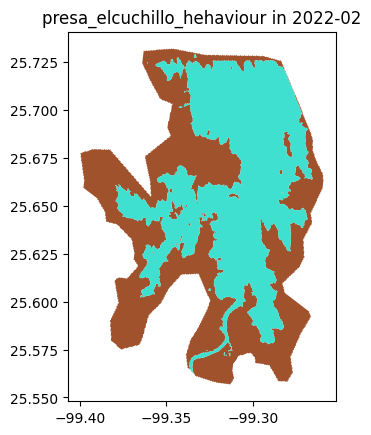

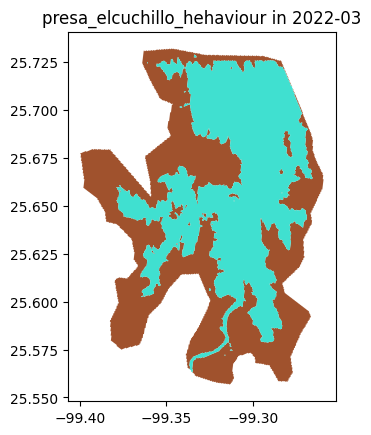

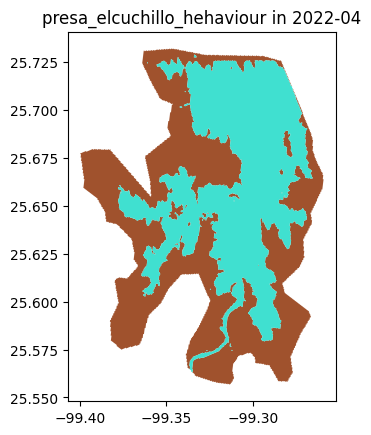

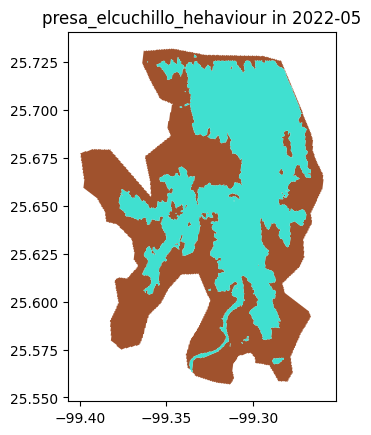

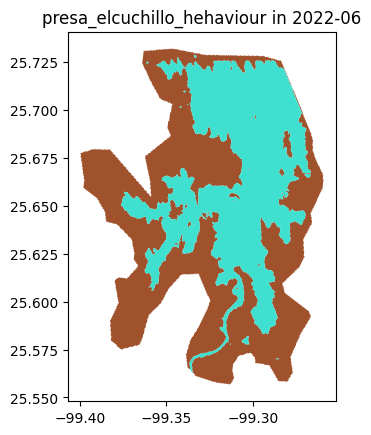

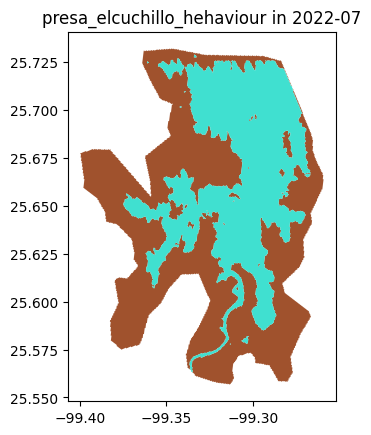

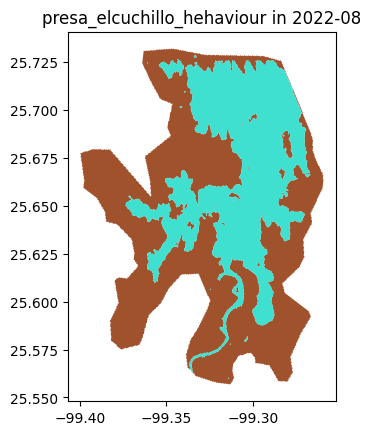

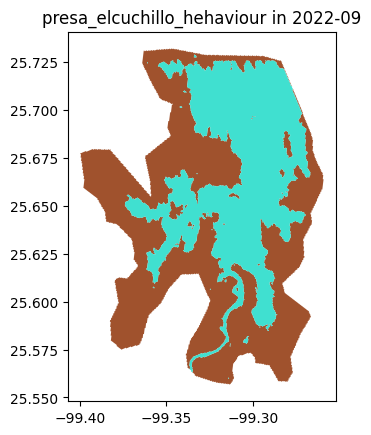

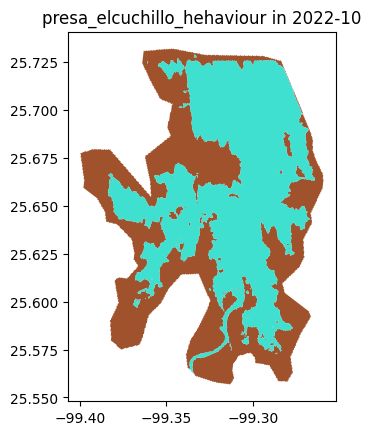

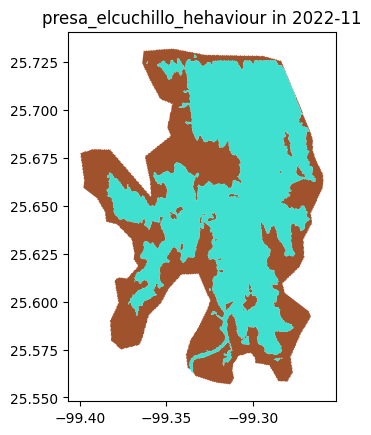

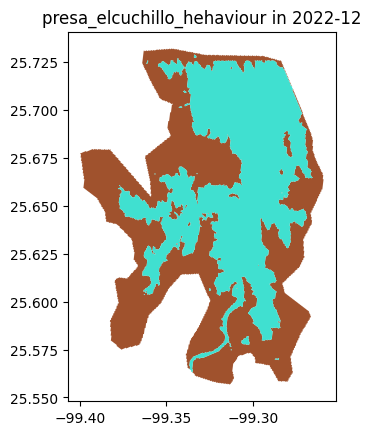

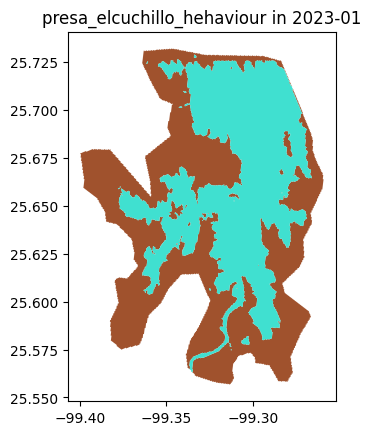

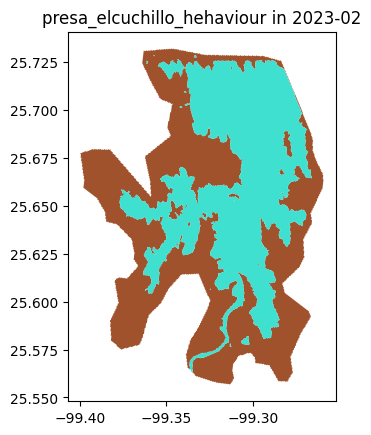

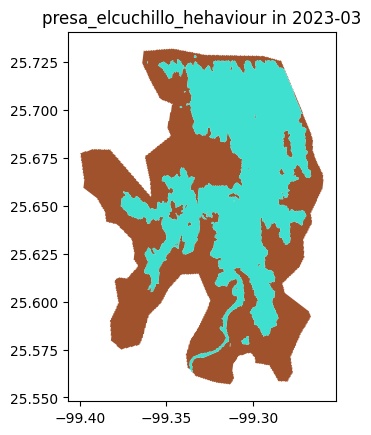

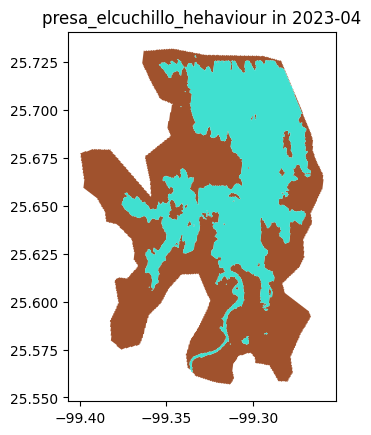

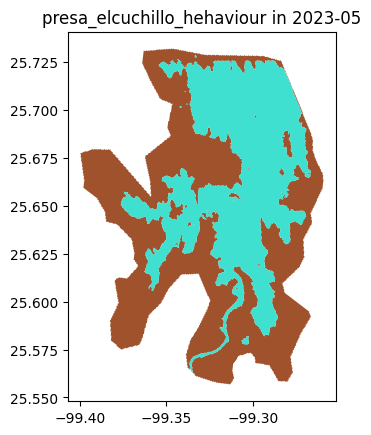

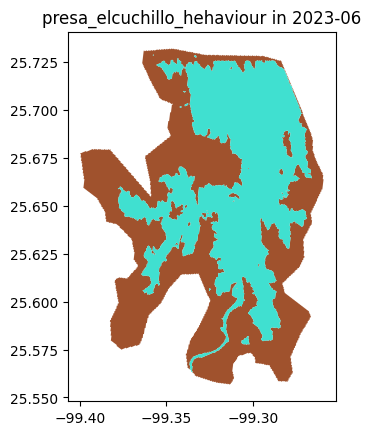

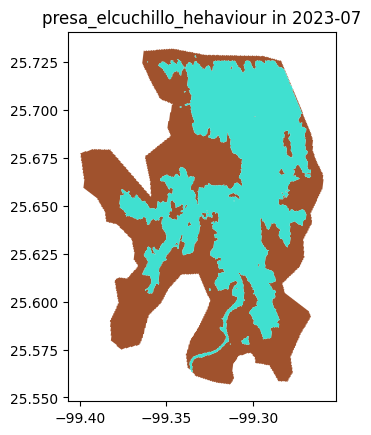

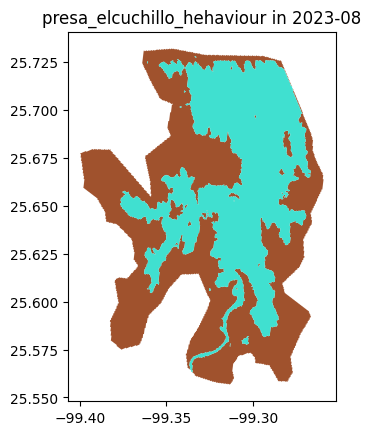

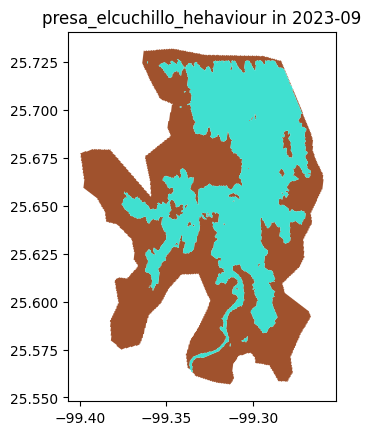

In [30]:
if plot_bydate:
    city = dam_ofinterest

    #------------------------------ Select data ------------------------------
    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
    complete_dataset_dams_city = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    years_summary = [2021,2022,2023]

    #Loop for each year in city
    for year in years_summary:
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
        by_year = complete_dataset_dams_city.loc[(complete_dataset_dams_city.year == year)]
    
        #Loop for each date in city
        for date in by_year.date.unique():
            #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
            month_dataset = by_year.loc[(by_year.date == date)]

            # Creating categories
            month_dataset['water_hex'] = np.nan

            month_dataset.loc[month_dataset.ndwi>=0.0 , 'water_hex'] = 'Water'        
            month_dataset.loc[(month_dataset.ndwi<-0.0), 'water_hex'] = 'Non-aqueous surfaces'

            # Ordering data
            categories = ['Non-aqueous surfaces', 'Water']
            month_dataset['water_hex'] = pd.Categorical(month_dataset['water_hex'], categories=categories, ordered=True)

            #Dissolve geometry
            month_dataset = month_dataset.to_crs("EPSG:6372")
            water_shape = month_dataset.dissolve('water_hex')
            water_shape = water_shape.to_crs("EPSG:4326")
            water_shape.reset_index(inplace=True)
            water_shape = water_shape[['water_hex','geometry']]
            
            # ---------- Plot ----------
            #Date behaviour
            water_shape.plot(column="water_hex",
                             legend=True,
                             color = ['sienna','turquoise'])

            # ---------- Format ----------
            # Format - Titles
            plt.title('{}_hehaviour in {}'.format(city,date))

            # ---------- Save Plot ----------
            if save_plots:
                plt.savefig("../../../output/figures/ndwi/maps_{}/{}_hehaviour in {}.svg".format(city,city,date))